In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


In [2]:
from utils.data_utils import load_movement_df, ward2size
from utils.plot_utils import *

path_to_data = os.path.join('..', '..', 'data')

# load scenarios for synthetic inferences
scenarios_df              = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))
movement_df, ward2cluster = load_movement_df(path_to_data, True) # movement data
ward2size                 = ward2size(movement_df)
ward2size                 = {r.ward_id: r.num_patients for idx_r, r in ward2size.iterrows()}


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_72586/1033347647.py:8: DtypeWarning: Columns (0,1,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  movement_df, ward2cluster = load_movement_df(path_to_data, True) # movement data


In [3]:
scenarios_df

,name_scenario,γ,β
0,scenario1,0.100,0.040
1,scenario2,0.050,0.035
2,scenario3,0.070,0.030
3,scenario4,0.100,0.010
4,scenario5,0.030,0.020
5,scenario6,0.030,0.025
6,scenario7,0.015,0.020
7,scenario8,0.150,0.040
8,scenario9,0.200,0.030
9,scenario10,0.300,0.035


In [37]:
# Choose a random scenario
from utils.infer_utils import create_df_response

row    = scenarios_df.iloc[np.random.randint(0, len(scenarios_df))]
ρ      = np.random.choice([4, 6, 8])
θ      = {}
θ['γ'] = row['γ']
θ['β'] = row['β']
θ['ρ'] = ρ / 100

path_to_scenario = os.path.join('..', '..', 'results', 'synthetic_inferences', f'ρ_{ρ}%', row.name_scenario)
samples_sim      = np.load(os.path.join(path_to_scenario, "simulation_infer.npz"))

# load samples
ward_colonized           = samples_sim["ward_colonized"]
ward_nosocomial          = samples_sim["ward_nosocomial"]
ward_imported            = samples_sim["ward_imported"]
ward_positive            = samples_sim["ward_positive"]
ward_negative            = samples_sim["ward_negative"]
cluster_colonized        = samples_sim["cluster_colonized"]
cluster_nosocomial       = samples_sim["cluster_nosocomial"]
cluster_imported         = samples_sim["cluster_imported"]
cluster_positive         = samples_sim["cluster_positive"]
cluster_negative         = samples_sim["cluster_negative"]

ttt          = ward_colonized.shape[0]
num_clusters = 6
# load samples at ward cluster level

cluster_colonized_df  = pd.concat([create_df_response(cluster_colonized[:, idx_cluster, :].T , time=ttt) for idx_cluster in range(num_clusters) ])
cluster_nosocomial_df = pd.concat([create_df_response(cluster_nosocomial[:, idx_cluster, :].T, time=ttt) for idx_cluster in range(num_clusters) ])
cluster_imported_df   = pd.concat([create_df_response(cluster_imported[:, idx_cluster, :].T  , time=ttt) for idx_cluster in range(num_clusters) ])
cluster_positive_df   = pd.concat([create_df_response(cluster_positive[:, idx_cluster, :].T  , time=ttt) for idx_cluster in range(num_clusters) ])
cluster_negative_df   = pd.concat([create_df_response(cluster_negative[:, idx_cluster, :].T  , time=ttt) for idx_cluster in range(num_clusters) ])

# resample sundays bc looks better when plotted
hosp_colonized_df  = create_df_response(cluster_colonized.sum(-2).T , time=ttt).resample("W-Sun").sum().reset_index()
hosp_nosocomial_df = create_df_response(cluster_nosocomial.sum(-2).T, time=ttt).resample("W-Sun").sum().reset_index()
hosp_imported_df   = create_df_response(cluster_imported.sum(-2).T  , time=ttt).resample("W-Sun").sum().reset_index()
hosp_positive_df   = create_df_response(cluster_positive.sum(-2).T  , time=ttt).resample("W-Sun").sum().reset_index()
hosp_negative_df   = create_df_response(cluster_negative.sum(-2).T  , time=ttt).resample("W-Sun").sum().reset_index()

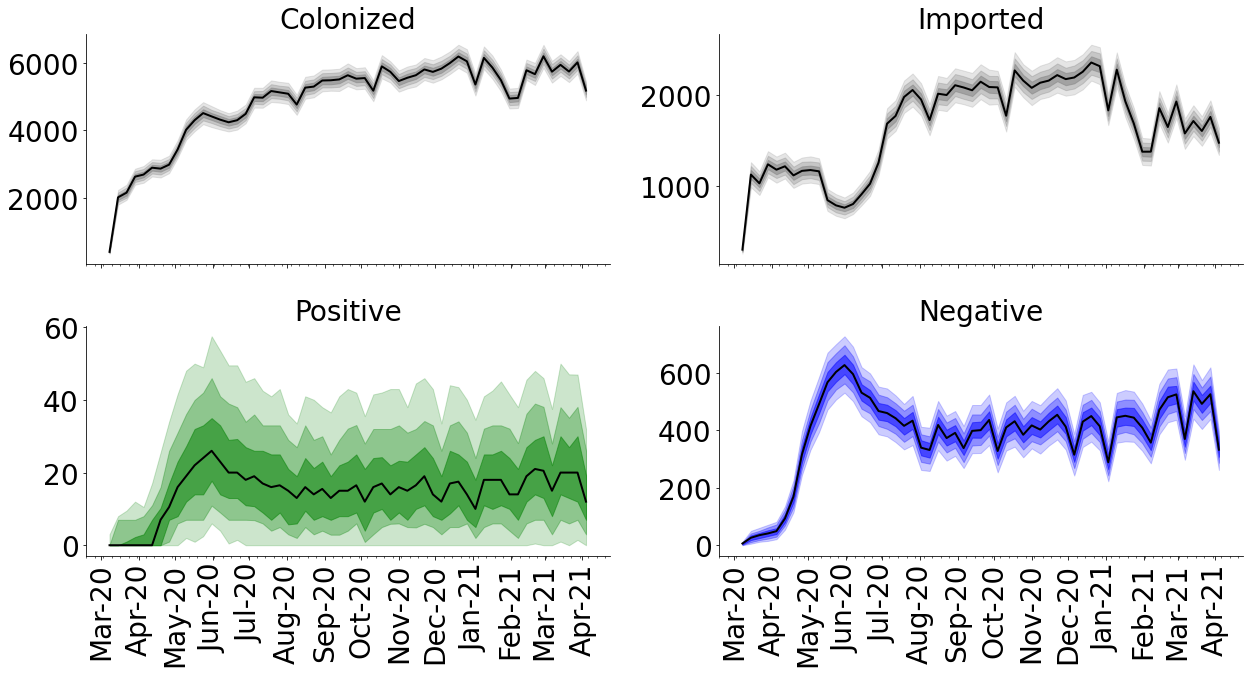

In [57]:
from utils.plot_utils import *

fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)

ax[0, 0].plot(hosp_colonized_df.date, hosp_colonized_df['median'], c='k', lw=2)
ax[0, 0].fill_between(hosp_colonized_df.date, hosp_colonized_df['low_95'], hosp_colonized_df['high_95'], color='gray', alpha=0.2)
ax[0, 0].fill_between(hosp_colonized_df.date, hosp_colonized_df['low_80'], hosp_colonized_df['high_80'], color='gray', alpha=0.3)
ax[0, 0].fill_between(hosp_colonized_df.date, hosp_colonized_df['low_50'], hosp_colonized_df['high_50'], color='gray', alpha=0.5)

ax[0, 1].plot(hosp_imported_df.date, hosp_imported_df['median'], c='k', lw=2)
ax[0, 1].fill_between(hosp_imported_df.date, hosp_imported_df['low_95'], hosp_imported_df['high_95'], color='gray', alpha=0.2)
ax[0, 1].fill_between(hosp_imported_df.date, hosp_imported_df['low_80'], hosp_imported_df['high_80'], color='gray', alpha=0.3)
ax[0, 1].fill_between(hosp_imported_df.date, hosp_imported_df['low_50'], hosp_imported_df['high_50'], color='gray', alpha=0.5)

ax[1, 0].plot(hosp_positive_df.date, hosp_positive_df['median'], c='k', lw=2)
ax[1, 0].fill_between(hosp_positive_df.date, hosp_positive_df['low_95'], hosp_positive_df['high_95'], color='green', alpha=0.2)
ax[1, 0].fill_between(hosp_positive_df.date, hosp_positive_df['low_80'], hosp_positive_df['high_80'], color='green', alpha=0.3)
ax[1, 0].fill_between(hosp_positive_df.date, hosp_positive_df['low_50'], hosp_positive_df['high_50'], color='green', alpha=0.5)

ax[1, 1].plot(hosp_negative_df.date, hosp_negative_df['median'], c='k', lw=2)
ax[1, 1].fill_between(hosp_negative_df.date, hosp_negative_df['low_95'], hosp_negative_df['high_95'], color='blue', alpha=0.2)
ax[1, 1].fill_between(hosp_negative_df.date, hosp_negative_df['low_80'], hosp_negative_df['high_80'], color='blue', alpha=0.3)
ax[1, 1].fill_between(hosp_negative_df.date, hosp_negative_df['low_50'], hosp_negative_df['high_50'], color='blue', alpha=0.5)
titles = ['Colonized', 'Imported', 'Positive', 'Negative']
for idx_axi, axi in enumerate(ax.flatten()):
    axi.set_title(titles[idx_axi])
    format_axis(axi)
plt.tight_layout()